# Домашнее задание 5

In [72]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [73]:
#!pip install --upgrade pip statsmodels

In [105]:
mix = pd.read_csv('lenex-corporation-shipment-of-mi.csv',',', index_col=['Month'], parse_dates=['Month'], dayfirst=True)

In [106]:
data=mix[:-1]
data.index = pd.to_datetime(data.index)
data['Lenex corporation: shipment of mixers Jan?67-Dec?71'] = data['Lenex corporation: shipment of mixers Jan?67-Dec?71'].apply(lambda x: int(x))

In [107]:
data.head()

,Lenex corporation: shipment of mixers Jan?67-Dec?71
Month,
1967-01-01,650
1967-02-01,610
1967-03-01,650
1967-04-01,620
1967-05-01,600


In [110]:
mix = data['Lenex corporation: shipment of mixers Jan?67-Dec?71'].copy()

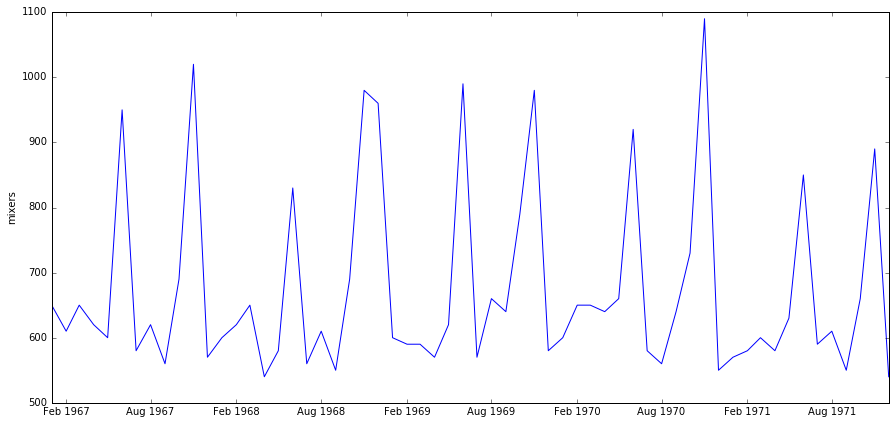

In [111]:
plt.figure(figsize(15,7))
plot(mix)
plt.ylabel('mixers')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.819812


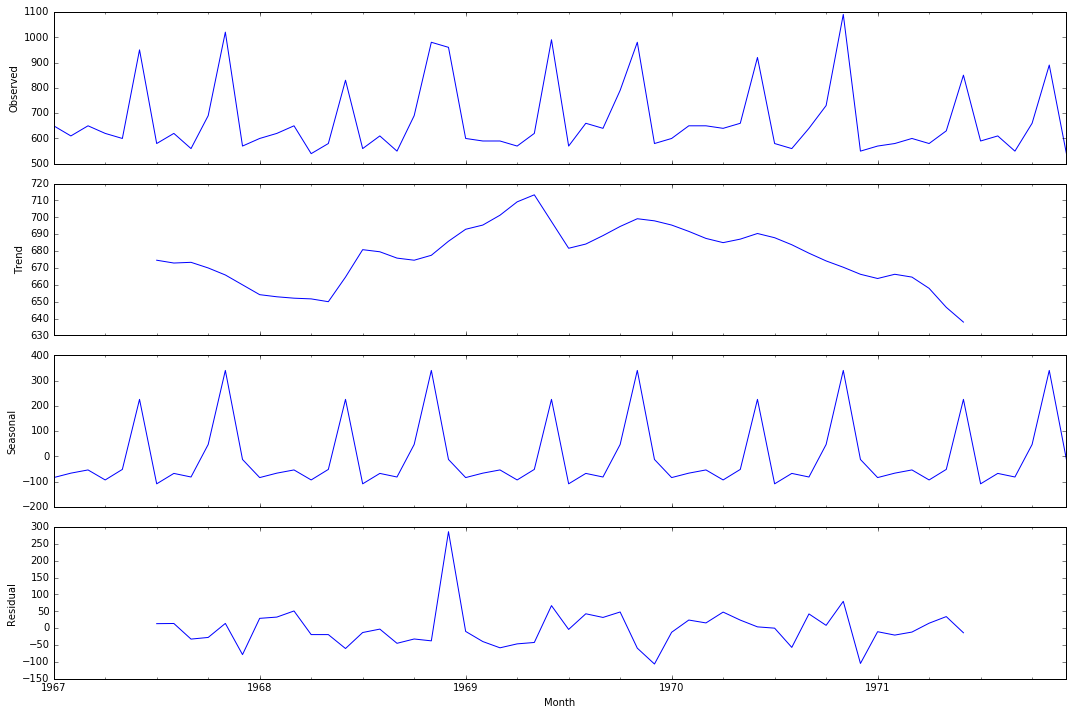

In [112]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['Lenex corporation: shipment of mixers Jan?67-Dec?71']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['Lenex corporation: shipment of mixers Jan?67-Dec?71'])[1])

Значение p-value = 0.819812 --> нет оснований отвергать нулевую гипотезу о нестационарности при разумных уровнях значимости.


### Стабилизация дисперсии

Преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: -4.537509
Критерий Дики-Фуллера: p=nan


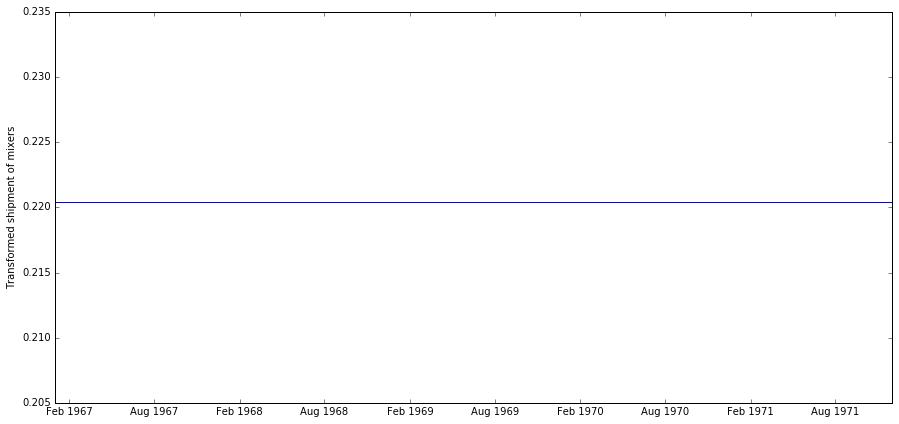

In [104]:
data['mix_box'], lmbda = stats.boxcox(mix)
plt.figure(figsize(15,7))
plot(data['mix_box'])
plt.ylabel(u'Transformed shipment of mixers')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['mix_box'])[1])

По критерию Дуки-Фуллера p-value = 0.832008 --> нет оснований отвергать нулевую гипотезу о нестационарности при разумных уровнях значимости.


Заметим, что преобразование Бокса-Кокса делает все значения нулевыми. Тогда при дальнейших расчетах будем пользоваться рядом без данного преобразования. 

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, значит в данных есть тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

In [136]:
data['mix'] = data['Lenex corporation: shipment of mixers Jan?67-Dec?71']

Критерий Дики-Фуллера: p=0.000000


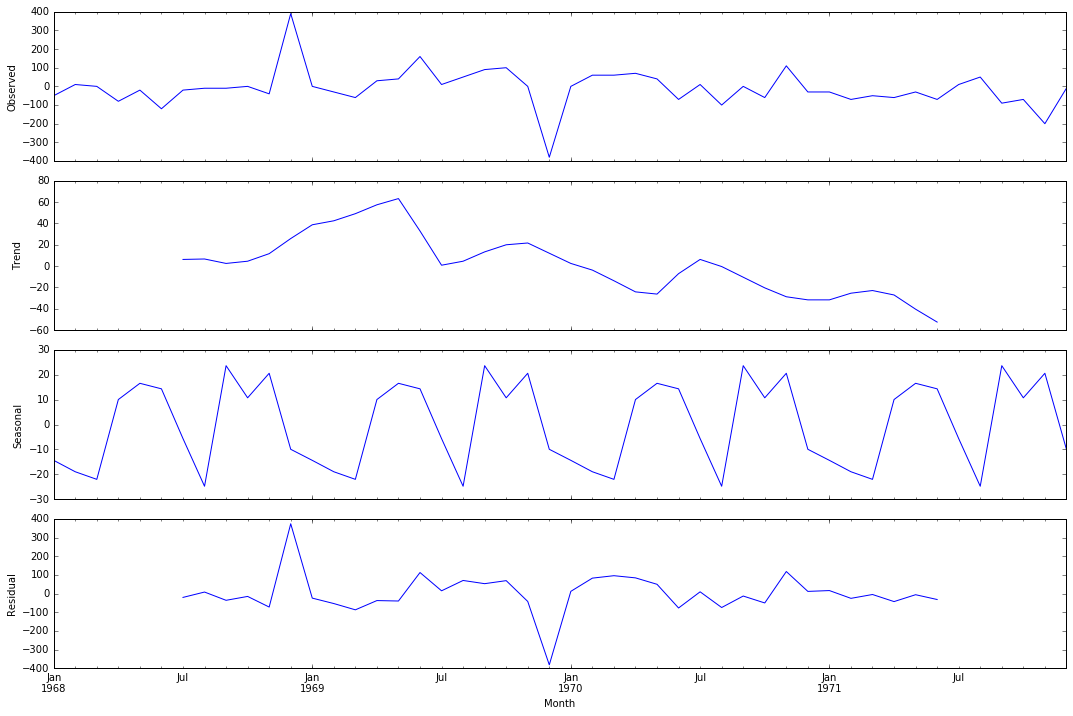

In [137]:
data['mix_diff'] = data.mix - data.mix.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.mix_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.mix_diff[12:])[1])

Теперь мы видим, что гипотеза о нестационарности уже отвергается, но применим еще обычное дифференцирование.

## Подбор модели

ACF и PACF полученного ряда:

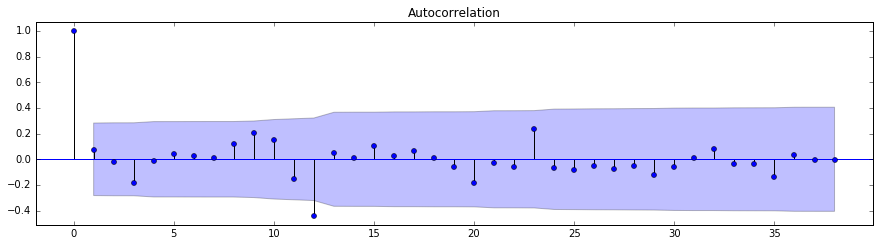

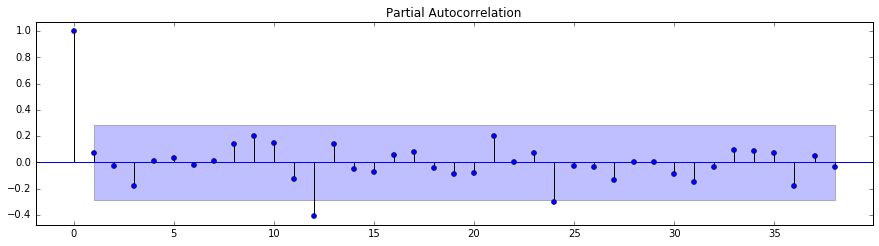

In [140]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.mix_diff[12:].values.squeeze(), lags=38, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.mix_diff[12:].values.squeeze(), lags=38, ax=ax)
pylab.show()

- По PACF --> p = 3 (тк 3 лага сильно отличных от нуля)
- По ACF --> q = 1 (тк после лага 1 значение функций резко падает) 
- d = 1 — порядок интегрированного ряда


Начальные приближения: Q=1, q=1, P=1, p=1

In [141]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [142]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [158]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.mix, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 1, 1)
wrong parameters: (0, 1, 0, 1)
wrong parameters: (0, 1, 1, 1)
wrong parameters: (0, 2, 0, 1)
wrong parameters: (0, 2, 1, 1)
wrong parameters: (1, 0, 0, 1)
wrong parameters: (1, 0, 1, 1)
wrong parameters: (1, 1, 0, 1)
wrong parameters: (1, 1, 1, 1)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (2, 0, 0, 1)
wrong parameters: (2, 0, 1, 1)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 0, 1)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 2, 1, 1)
wrong parameters: (3, 0, 0, 1)
wrong parameters: (3, 0, 1, 1)
wrong parameters: (3, 1, 0, 1)
wrong parameters: (3, 1, 1, 1)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (4, 0, 0, 1)
wrong parameters: (4, 0, 1, 1)
wrong parameters: (4, 1, 0, 1)
wrong pa

In [159]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
2   (0, 1, 1, 0)  562.386790
8   (1, 1, 1, 0)  564.380127
4   (0, 2, 1, 0)  564.515604
10  (1, 2, 1, 0)  566.247478
16  (3, 1, 1, 0)  566.342704


Лучшая модель:

In [160]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                mix   No. Observations:                   60
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -278.193
Date:                            Fri, 16 Dec 2016   AIC                            562.387
Time:                                    23:43:46   BIC                            568.670
Sample:                                01-01-1967   HQIC                           564.844
                                     - 12-01-1971                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8717      0.154     -5.661      0.000      -1.174      -0.570
ar.S.L12      -0.5955      0.042   

Её остатки:

Критерий Стьюдента: p=0.960202
Критерий Дики-Фуллера: p=0.000000


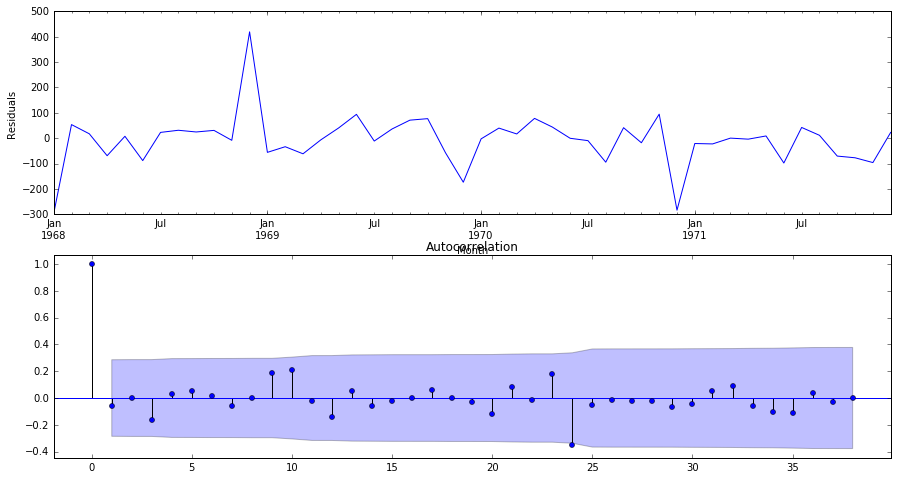

In [161]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[12:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=38, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Посмотрим, насколько хорошо модель описывает данные:

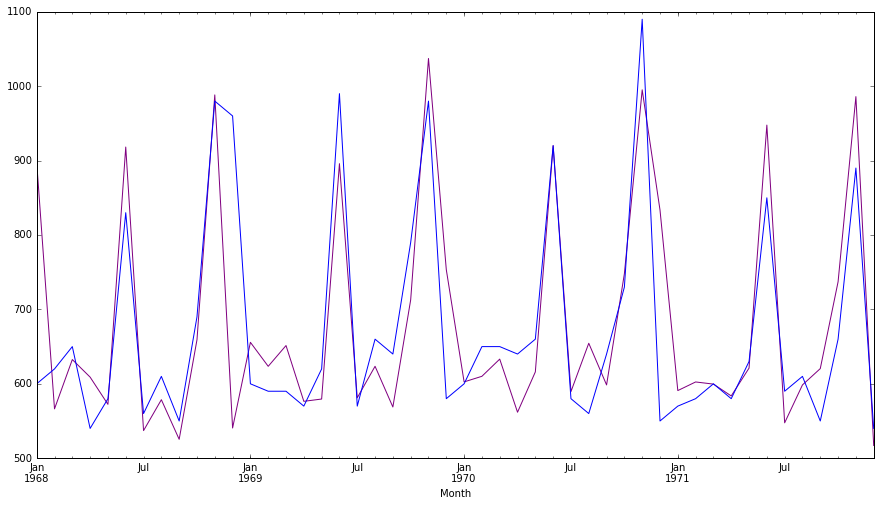

In [162]:
best_model.fittedvalues[12:].plot(color = 'purple')
data['mix'][12:].plot();

### Прогноз

In [171]:
data.tail()

,Lenex corporation: shipment of mixers Jan?67-Dec?71,mix,mix_diff
Month,,,
1971-08-01,610,610,50.0
1971-09-01,550,550,-90.0
1971-10-01,660,660,-70.0
1971-11-01,890,890,-200.0
1971-12-01,540,540,-10.0


/Users/mariago/anaconda/lib/python3.5/site-packages/dateutil/rrule.py:450: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)


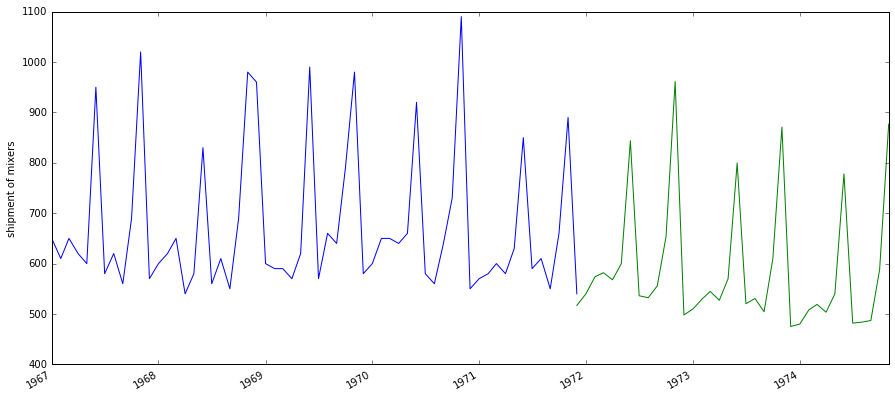

In [174]:
data2 = data[['Lenex corporation: shipment of mixers Jan?67-Dec?71']]
date_list = [datetime.datetime.strptime("1971-12-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = best_model.predict(start="1971-12-01", end="1975-01-01")

plt.figure(figsize(15,7))
data2['Lenex corporation: shipment of mixers Jan?67-Dec?71'].plot()
data2.forecast.plot()
plt.ylabel('shipment of mixers')
pylab.show()